### 三种神经元模型的刺激频率发放关系

由于模型电流值采用归一化处理，因此电流的绝对值不一定有明确的意义，但是可以根据此观察阈刺激大小和冲动发放频率和刺激的关系

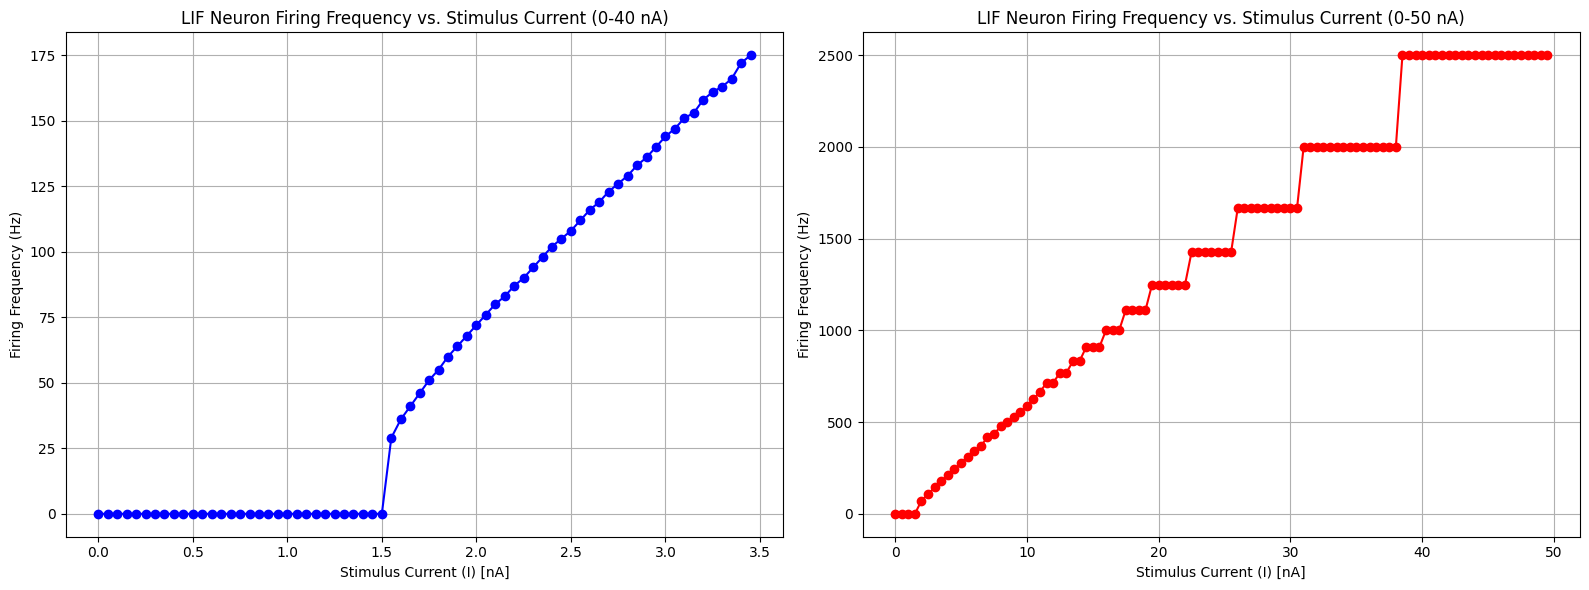

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# LIF模型的常数
V_rest = -65.0      # 静息膜电位，单位 mV
V_th = -50.0        # 膜电位阈值，单位 mV
V_reset = -65.0     # 膜电位重置值，单位 mV
R = 10.0            # 膜电阻，单位 MΩ
tau_m = 10.0        # 膜时间常数，单位 ms
C_m = tau_m / R     # 膜电容，单位 μF/cm^2
I_ext = 0.0         # 外部电流（单位 nA）

# 定义LIF模型
def lif(I_ext, T=1000, dt=0.1):
    V = V_rest     # 初始膜电位
    spikes = []    # 存储发放事件的时间
    V_trace = []   # 存储膜电位轨迹
    time = np.arange(0, T, dt)
    
    for t in time:
        # 更新膜电位
        dV = (- (V - V_rest) + R * I_ext) / tau_m
        V += dV * dt

        # 检查是否发生放电
        if V >= V_th:
            spikes.append(t)  # 记录发放时间
            V = V_reset       # 重置膜电位

        # 存储膜电位轨迹
        V_trace.append(V)
    
    # 计算发放频率
    spike_freq = len(spikes) / (T / 1000)  # 单位Hz
    return spike_freq, spikes, V_trace, time

# 计算不同外部电流下的发放频率
currents0 = np.arange(0, 3.5, 0.05)  # 电流范围，从5到40 nA
frequencies0 = []
for I in currents0:
    spike_freq, _, _, _ = lif(I)
    frequencies0.append(spike_freq)

currents1 = np.arange(0, 50, 0.5)  # 电流范围，从5到40 nA
frequencies1 = []
for I in currents1:
    spike_freq, _, _, _ = lif(I)
    frequencies1.append(spike_freq)

# 创建横向排列的两个子图
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 第一个子图，原始横坐标范围
axes[0].plot(currents0, frequencies0, marker='o', linestyle='-', color='b')
axes[0].set_title('LIF Neuron Firing Frequency vs. Stimulus Current (0-40 nA)')
axes[0].set_xlabel('Stimulus Current (I) [nA]')
axes[0].set_ylabel('Firing Frequency (Hz)')
axes[0].grid(True)

# 第二个子图，横坐标范围扩展
axes[1].plot(currents1, frequencies1, marker='o', linestyle='-', color='r')
axes[1].set_title('LIF Neuron Firing Frequency vs. Stimulus Current (0-50 nA)')
axes[1].set_xlabel('Stimulus Current (I) [nA]')
axes[1].set_ylabel('Firing Frequency (Hz)')
axes[1].grid(True)

# 调整布局，使得两个子图之间不会重叠
plt.tight_layout()
plt.show()



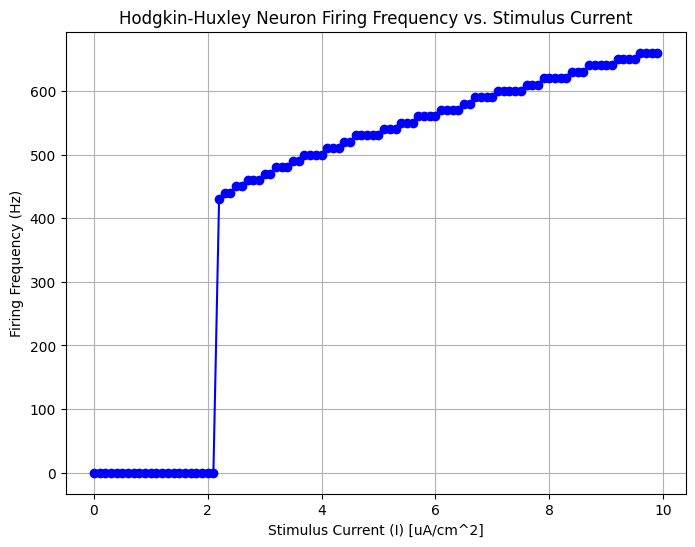

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# 霍奇金-赫克斯利模型的常数
C_m = 1.0        # 膜电容，单位 μF/cm^2
g_Na = 120.0     # 钠离子电导，单位 mS/cm^2
g_K = 36.0       # 钾离子电导，单位 mS/cm^2
g_L = 0.3        # 漏电导，单位 mS/cm^2
E_Na = 50.0      # 钠离子反转电位，单位 mV
E_K = -77.0      # 钾离子反转电位，单位 mV
E_L = -54.387    # 漏电流反转电位，单位 mV

# 定义门控变量的稳态值和时间常数
def alpha_m(V): return (2.5 - 0.1 * (V + 65)) / (np.exp(2.5 - 0.1 * (V + 65)) - 1) if V != -65 else 0
def beta_m(V): return 4 * np.exp(-(V + 65) / 18)
def alpha_h(V): return 0.07 * np.exp(-(V + 65) / 20)
def beta_h(V): return 1 / (np.exp(3.0 - 0.1 * (V + 65)) + 1)
def alpha_n(V): return (0.1 - 0.01 * (V + 65)) / (np.exp(1.0 - 0.1 * (V + 65)) - 1) if V != -65 else 0
def beta_n(V): return 0.125 * np.exp(-(V + 65) / 80)

# 定义HH模型
def hodgkin_huxley(I_ext, T=100, dt=0.01):
    V = -65.0   # 初始膜电位，单位 mV
    n = 0.317   # 初始钾离子通道门控变量
    m = 0.052   # 初始钠离子通道门控变量
    h = 0.596   # 初始钠离子通道门控变量
    time = np.arange(0, T, dt)
    V_trace = []
    spike_count = 0

    for t in time:
        # 计算离子电流
        I_Na = g_Na * m**3 * h * (V - E_Na)
        I_K = g_K * n**4 * (V - E_K)
        I_L = g_L * (V - E_L)

        # 膜电位变化的方程
        dV = (I_ext - (I_Na + I_K + I_L)) / C_m
        V += dV * dt

        # 门控变量更新
        dm = alpha_m(V) * (1 - m) - beta_m(V) * m
        dh = alpha_h(V) * (1 - h) - beta_h(V) * h
        dn = alpha_n(V) * (1 - n) - beta_n(V) * n
        m += dm * dt
        h += dh * dt
        n += dn * dt

        # 存储膜电位
        V_trace.append(V)

        # 检测是否发生动作电位
        if V >= 30:
            spike_count += 1
            V = -65.0   # 重置膜电位
            m = alpha_m(V) / (alpha_m(V) + beta_m(V))  # 更新门控变量
            h = alpha_h(V) / (alpha_h(V) + beta_h(V))
            n = alpha_n(V) / (alpha_n(V) + beta_n(V))

    # 计算发放频率（Hz）
    spike_freq = spike_count / (T / 1000)  # 单位Hz
    return spike_freq, V_trace

# 计算不同外部电流下的发放频率
currents = np.arange(0, 10, 0.1)  # 电流范围，从5到40
frequencies = []

for I in currents:
    spike_freq, _ = hodgkin_huxley(I)
    frequencies.append(spike_freq)

# 绘制电流-发放频率关系图
plt.figure(figsize=(8, 6))
plt.plot(currents, frequencies, marker='o', linestyle='-', color='b')
plt.title('Hodgkin-Huxley Neuron Firing Frequency vs. Stimulus Current')
plt.xlabel('Stimulus Current (I) [uA/cm^2]')
plt.ylabel('Firing Frequency (Hz)')
plt.grid(True)
plt.show()


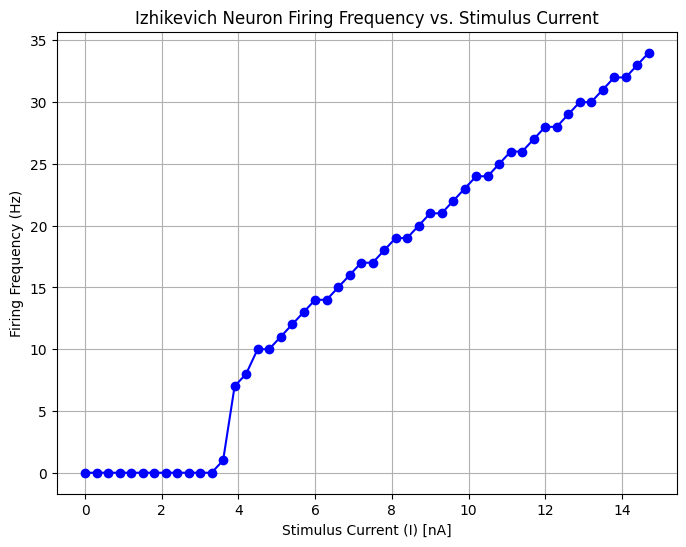

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Izhikevich模型的参数
a = 0.02   # 膜恢复变量的时间常数
b = 0.2    # 恢复变量的灵敏度
c = -65    # 膜电位重置值
d = 8      # 恢复变量重置值

# 定义Izhikevich模型
def izhikevich(I, T=1000, dt=0.1):
    v = -65.0  # 初始膜电位
    u = b * v  # 初始恢复变量
    spike_count = 0  # 发放次数计数器
    times = np.arange(0, T, dt)  # 时间向量

    # 存储膜电位
    v_trace = []

    # 模拟神经元活动
    for t in times:
        # 更新膜电位和恢复变量
        dv = 0.04 * v**2 + 5 * v + 140 - u + I
        du = a * (b * v - u)
        
        v += dv * dt
        u += du * dt
        
        # 当膜电位超过阈值时重置
        if v >= 30:
            v = c
            u += d
            spike_count += 1
        
        v_trace.append(v)

    # 计算发放频率
    spike_freq = spike_count / (T / 1000)  # 单位为Hz
    return spike_freq, v_trace

# 计算不同电流下的发放频率
currents = np.arange(0,15, 0.3)  # 电流范围，从5到40
frequencies = []

for I in currents:
    spike_freq, _ = izhikevich(I)
    frequencies.append(spike_freq)

# 绘制电流与发放频率关系图
plt.figure(figsize=(8, 6))
plt.plot(currents, frequencies, marker='o', linestyle='-', color='b')
plt.title('Izhikevich Neuron Firing Frequency vs. Stimulus Current')
plt.xlabel('Stimulus Current (I) [nA]')
plt.ylabel('Firing Frequency (Hz)')
plt.grid(True)
plt.show()
